Dataset : https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain

In [1]:
import json
import random
from pathlib import Path
from enum import Enum
from typing import Tuple, List, Optional, Callable, Union, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [2]:
class SplitType(Enum):
    """Enumeration for dataset split types"""
    TRAIN = 'train'
    VAL = 'val'
    TEST = 'test'


class Sentinel(Dataset):
    """
    A PyTorch Dataset for handling Sentinel-1&2 Image Pairs.
    
    This dataset assumes a directory structure of:
    root_dir/
        category1/
            s1/
                image1.png
                image2.png
            s2/
                image1.png
                image2.png
        category2/
            ...
    
    This class has support for train/val/test splits. When `split_type` is `None`, 
    uses the complete dataset. When `split_type` is specified 
    (``'train'``, ``'val'``, ``'test'``), the dataset can be split using:

    1. A split that defines which images belong to which split
    2. Random splitting with a specified ratio

    Args:
        root_dir (str | Path): Root directory containing the dataset
        split_type (str | None): Which split to use ('train', 'val', 'test') or None for full dataset
        transform (callable, optional): Transform to apply to both SAR and optical images
        split_mode (str, optional): How to split the dataset ('random', 'split')
        split_ratio (Tuple[float, float, float], optional): Ratio for train/val/test splits
        split_file (str | Path, optional): predefined the splits
        seed (int, optional): Random seed for reproducible splitting
        
    Attributes:
        root_dir (Path): Path to the dataset root directory
        transform (callable): Transform pipeline for the images
        image_pairs (List[Tuple[Path, Path]]): List of paired image paths (SAR, optical)
    """
    def __init__(self,
                 root_dir: Union[str, Path],
                 split_type: Optional[str] = None,
                 transform: Optional[Callable] = None,
                 split_mode: Literal['random', 'split'] = 'random',
                 split_ratio: Tuple[float, float, float] = (0.7, 0.15, 0.15),
                 split_file: Optional[Union[str, Path]] = None,
                 seed: int = 42):
        self.root_dir = Path(root_dir)
        if not self.root_dir.exists():
            raise FileNotFoundError(f"Dataset root directory not found: {self.root_dir}")
        
        # Convert string split_type to enum if provided
        self.split_type = SplitType(split_type) if split_type else None

        # Default transform pipeline
        self.transform = transform if transform else v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

        # Collect image pairs
        self.all_image_pairs = self._collect_images()

        # Apply split if specified
        if split_type:
            if split_mode == 'split' and split_file:
                self.image_pairs = self._apply_predefined_split(split_file)
            elif split_mode == 'random':
                self.image_pairs = self._apply_random_split(split_ratio, seed)
            else:
                raise ValueError("Invalid split configuration. Use either 'split' with a split_file or 'random' with split_ratio")
        else:
            # If no split type specified, use all images
            self.image_pairs = self.all_image_pairs

        print(f'Total image pairs found: {len(self)}')

    def _collect_images(self) -> List[Tuple[Path, Path]]:
        """
        Collects paired SAR (s1) and optical (s2) image paths from the dataset directory.
            
        Returns:
            List[Tuple[Path, Path]]: List of (SAR image path, optical image path) pairs
        """
        image_pairs = []
        
        # Iterate through category subdirectories
        for category in self.root_dir.iterdir():
            # Check if it's a directory
            if not category.is_dir():
                continue

            s1_path = category / 's1'
            s2_path = category / 's2'
            
            if not (s1_path.is_dir() and s2_path.is_dir()):
                # print(f"Missing s1 or s2 subdirectory in category: {category.name}")
                continue

            # Collect pairs
            for s1_file in s1_path.glob('*.png'):
                # Convert SAR filename to optical filename
                # e.g. 'ROIs1970_fall_s1_13_p265.png' -> 'ROIs1970_fall_s2_13_p265.png'
                s2_filename = list(s1_file.name.split('_'))
                s2_filename[2] = 's2'
                s2_file = s2_path / '_'.join(s2_filename)

                if not s2_file.exists():
                    # print(f"Missing optical image for SAR image: {s1_file.name} - {s2_file.name}")
                    continue

                image_pairs.append((s1_file, s2_file))
        
        return image_pairs
    
    def _apply_predefined_split(self, split_file: Union[str, Path]) -> List[Tuple[Path, Path]]:
        """
        Applies a predefined split from a JSON file.
        
        Args:
            split_file: Path to JSON file containing split definitions
            
        Returns:
            List[Tuple[Path, Path]]: Image pairs for the specified split
        """
        try:
            with open(split_file, 'r') as f:
                splits = json.load(f)
                
            if self.split_type.value not in splits['data']:
                raise ValueError(f"Split type {self.split_type.value} not found in split file")
            
            split_filenames = set(splits['data'][self.split_type.value]) # data['split']
            return [pair for pair in self.all_image_pairs 
                if any(p.name in split_filenames for p in pair[:2])]
        except Exception as e:
            print(f'Could not open split file\n\t{e}')
            raise

    def _apply_random_split(
        self, 
        split_ratio: Tuple[float, float, float],
        seed: int
    ) -> List[Tuple[Path, Path]]:
        """
        Randomly splits the dataset according to the given ratios.
        
        Args:
            split_ratio: Tuple of (train, val, test) ratios
            seed: Random seed for reproducibility
            
        Returns:
            List[Tuple[Path, Path]]: Image pairs for the specified split
        """
        if sum(split_ratio) != 1:
            raise ValueError("Split ratios must sum to 1")
        
        # Set random seed for reproducibility
        random.seed(seed)
        
        # Shuffle indices
        indices = list(range(len(self.all_image_pairs)))
        random.shuffle(indices)
        
        # Calculate split points
        train_end = int(len(indices) * split_ratio[0])
        val_end = train_end + int(len(indices) * split_ratio[1])
        
        # Select appropriate slice based on split type
        if self.split_type == SplitType.TRAIN:
            split_indices = indices[:train_end]
        elif self.split_type == SplitType.VAL:
            split_indices = indices[train_end:val_end]
        else:  # TEST
            split_indices = indices[val_end:]
            
        return [self.all_image_pairs[i] for i in split_indices]
    
    def save_split(self, output_file: Union[str, Path], append: bool = False):
        """
        Saves the current split configuration to a JSON file.
        
        Args:
            output_file: Path to save the split configuration
            append: Define which mode you want to open the file in
        """
        if self.split_type:
            split = self.split_type.value
            split_info = {
                'data' : {
                    split: [p[0].name for p in self.image_pairs]
                }
            }
            mode = 'a' if append else 'w'
            with open(output_file, mode) as f:
                json.dump(split_info, f, indent=2)
    
    def __len__(self):
        """Returns the total number of image pairs in the dataset."""
        return len(self.image_pairs)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the image pair at the given index.
        
        Args:
            idx (int): Index of the image pair to retrieve
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Processed (SAR image, optical image) pair
        """
        # Get paths for SAR and optical images
        s1_path, s2_path = self.image_pairs[idx]
        
        # Load images
        s1_image = Image.open(s1_path).convert('RGB')
        s2_image = Image.open(s2_path).convert('RGB')
        
        # Apply transforms
        s1_image = self.transform(s1_image)
        s2_image = self.transform(s2_image)
        
        return s1_image, s2_image

# Pix2Pix Model Implementation

## Building Blocks

In [3]:
class DownsamplingBlock(nn.Module):
    """Defines the Unet downsampling block. 
    
    Consists of Convolution-BatchNorm-ReLU layer with k filters.
    """
    def __init__(self, c_in, c_out, kernel_size=4, stride=2, 
                 padding=1, negative_slope=0.2, use_norm=True):
        """
        Initializes the UnetDownsamplingBlock.
        
        Args:
            c_in (int): The number of input channels.
            c_out (int): The number of output channels.
            kernel_size (int, optional): The size of the convolving kernel. Default is 4.
            stride (int, optional): Stride of the convolution. Default is 2.
            padding (int, optional): Zero-padding added to both sides of the input. Default is 0.
            negative_slope (float, optional): Negative slope for the LeakyReLU activation function. Default is 0.2.
            use_norm (bool, optinal): If use norm layer. If True add a BatchNorm layer after Conv. Default is True.
        """
        super(DownsamplingBlock, self).__init__()
        block = []
        block += [nn.Conv2d(in_channels=c_in, out_channels=c_out,
                          kernel_size=kernel_size, stride=stride, padding=padding,
                          bias=(not use_norm) # No need to use a bias if there is a batchnorm layer after conv
                          )]
        if use_norm:
            block += [nn.BatchNorm2d(num_features=c_out)]
        
        block += [nn.LeakyReLU(negative_slope=negative_slope)]

        self.conv_block = nn.Sequential(*block)
        
    def forward(self, x):
        return self.conv_block(x)

In [4]:
class UpsamplingBlock(nn.Module):
    """Defines the Unet upsampling block.
    """
    def __init__(self, c_in, c_out, kernel_size=4, stride=2, 
                 padding=1, use_dropout=False, use_upsampling=False, mode='nearest'):
        
        """
        Initializes the Unet Upsampling Block.
        
        Args:
            c_in (int): The number of input channels.
            c_out (int): The number of output channels.
            kernel_size (int, optional): Size of the convolving kernel. Default is 4.
            stride (int, optional): Stride of the convolution. Default is 2.
            padding (int, optional): Zero-padding added to both sides of the input. Default is 0.
            use_dropout (bool, optional): if use dropout layers. Default is False.
            upsample (bool, optinal): if use upsampling rather than transpose convolution. Default is False.
            mode (str, optional): the upsampling algorithm: one of 'nearest', 
                'bilinear', 'bicubic'. Default: 'nearest'
        """
        super(UpsamplingBlock, self).__init__()
        block = []
        if use_upsampling:
            # Transpose convolution causes checkerboard artifacts. Upsampling
            # followed by a regular convolutions produces better results appearantly
            # Please check for further reading: https://distill.pub/2016/deconv-checkerboard/
            # Odena, et al., "Deconvolution and Checkerboard Artifacts", Distill, 2016. http://doi.org/10.23915/distill.00003
            
            mode = mode if mode in ('nearest', 'bilinear', 'bicubic') else 'nearest'
            
            block += [nn.Sequential(
                nn.Upsample(scale_factor=2, mode=mode),
                nn.Conv2d(in_channels=c_in, out_channels=c_out,
                          kernel_size=3, stride=1, padding=padding,
                          bias=False
                          )
                )]
        else:
            block += [nn.ConvTranspose2d(in_channels=c_in, 
                                         out_channels=c_out,
                                         kernel_size=kernel_size, 
                                         stride=stride,
                                         padding=padding, bias=False
                                         )
                     ]
        
        block += [nn.BatchNorm2d(num_features=c_out)]

        if use_dropout:
            block += [nn.Dropout(0.5)]
            
        block += [nn.ReLU()]

        self.conv_block = nn.Sequential(*block)

    def forward(self, x):
        return self.conv_block(x)

## Networks

### Generator

In [5]:
class UnetEncoder(nn.Module):
    """Create the Unet Encoder Network.
    
    C64-C128-C256-C512-C512-C512-C512-C512
    """
    def __init__(self, c_in=3, c_out=512):
        """
        Constructs the Unet Encoder Network.

        Ck denote a Convolution-BatchNorm-ReLU layer with k filters.
            C64-C128-C256-C512-C512-C512-C512-C512
        Args:
            c_in (int, optional): Number of input channels.
            c_out (int, optional): Number of output channels. Default is 512.
        """
        super(UnetEncoder, self).__init__()
        self.enc1 = DownsamplingBlock(c_in, 64, use_norm=False) # C64
        self.enc2 = DownsamplingBlock(64, 128) # C128
        self.enc3 = DownsamplingBlock(128, 256) # C256
        self.enc4 = DownsamplingBlock(256, 512) # C512
        self.enc5 = DownsamplingBlock(512, 512) # C512
        self.enc6 = DownsamplingBlock(512, 512) # C512
        self.enc7 = DownsamplingBlock(512, 512) # C512
        self.enc8 = DownsamplingBlock(512, c_out) # C512

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        x6 = self.enc6(x5)
        x7 = self.enc7(x6)
        x8 = self.enc8(x7)
        out = [x8, x7, x6, x5, x4, x3, x2, x1] # latest activation is the first element
        return out

In [6]:
class UnetDecoder(nn.Module):
    """Creates the Unet Decoder Network.
    """
    def __init__(self, c_in=512, c_out=64, use_upsampling=False, mode='nearest'):
        """
        Constructs the Unet Decoder Network.

        Ck denote a Convolution-BatchNorm-ReLU layer with k filters.
        
        CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%.
            CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
        Args:
            c_in (int): Number of input channels.
            c_out (int, optional): Number of output channels. Default is 512.
            use_upsampling (bool, optional): Upsampling method for decoder. 
                If True, use upsampling layer followed regular convolution layer.
                If False, use transpose convolution. Default is False
            mode (str, optional): the upsampling algorithm: one of 'nearest', 
                'bilinear', 'bicubic'. Default: 'nearest'
        """
        super(UnetDecoder, self).__init__()
        self.dec1 = UpsamplingBlock(c_in, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode) # CD512
        self.dec2 = UpsamplingBlock(1024, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode) # CD1024
        self.dec3 = UpsamplingBlock(1024, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode) # CD1024
        self.dec4 = UpsamplingBlock(1024, 512, use_upsampling=use_upsampling, mode=mode) # C1024
        self.dec5 = UpsamplingBlock(1024, 256, use_upsampling=use_upsampling, mode=mode) # C1024
        self.dec6 = UpsamplingBlock(512, 128, use_upsampling=use_upsampling, mode=mode) # C512
        self.dec7 = UpsamplingBlock(256, 64, use_upsampling=use_upsampling, mode=mode) # C256
        self.dec8 = UpsamplingBlock(128, c_out, use_upsampling=use_upsampling, mode=mode) # C128
    

    def forward(self, x):
        x9 = torch.cat([x[1], self.dec1(x[0])], 1) # (N,1024,H,W)
        x10 = torch.cat([x[2], self.dec2(x9)], 1) # (N,1024,H,W)
        x11 = torch.cat([x[3], self.dec3(x10)], 1) # (N,1024,H,W)
        x12 = torch.cat([x[4], self.dec4(x11)], 1) # (N,1024,H,W)
        x13 = torch.cat([x[5], self.dec5(x12)], 1) # (N,512,H,W)
        x14 = torch.cat([x[6], self.dec6(x13)], 1) # (N,256,H,W)
        x15 = torch.cat([x[7], self.dec7(x14)], 1) # (N,128,H,W)
        out = self.dec8(x15) # (N,64,H,W)
        return out

Generator

In [7]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""
    def __init__(self, c_in=3, c_out=3, use_upsampling=False, mode='nearest'):
        """
        Constructs a Unet generator
        Args:
            c_in (int): The number of input channels.
            c_out (int): The number of output channels.
            use_upsampling (bool, optional): Upsampling method for decoder. 
                If True, use upsampling layer followed regular convolution layer.
                If False, use transpose convolution. Default is False
            mode (str, optional): the upsampling algorithm: one of 'nearest', 
                'bilinear', 'bicubic'. Default: 'nearest'
        """
        super(UnetGenerator, self).__init__()
        self.encoder = UnetEncoder(c_in=c_in)
        self.decoder = UnetDecoder(use_upsampling=use_upsampling, mode=mode)
        # In the paper, the authors state:
        #   """
        #       After the last layer in the decoder, a convolution is applied
        #       to map to the number of output channels (3 in general, except
        #       in colorization, where it is 2), followed by a Tanh function.
        #   """
        # However, in the official Lua implementation, only a Tanh layer is applied.
        # Therefore, I took the liberty of adding a convolutional layer with a 
        # kernel size of 3.
        # For more information please check the paper and official github repo:
        # https://github.com/phillipi/pix2pix
        # https://arxiv.org/abs/1611.07004
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=c_out,
                      kernel_size=3, stride=1, padding=1,
                      bias=True
                      ), 
            nn.Tanh()
            )
    
    def forward(self, x):
        outE = self.encoder(x)
        outD = self.decoder(outE)
        out = self.head(outD)
        return out

### Discriminator

Pixel Discriminator (1x1 PatchGAN)

In [8]:
class PixelDiscriminator(nn.Module):
    """Create a PixelGAN discriminator (1x1 PatchGAN discriminator)"""
    def __init__(self, c_in=3, c_hid=64):
        """Constructs a PixelGAN discriminator, a special form of PatchGAN Discriminator.
        All convolutions are 1x1 spatial filters

        Args:
            c_in (int, optional): The number of input channels. Defaults to 3.
            c_hid (int, optional): The number of channels after first conv layer.
                Defaults to 64.
        """
        super(PixelDiscriminator, self).__init__()
        self.model = nn.Sequential(
            DownsamplingBlock(c_in, c_hid, kernel_size=1, stride=1, padding=0, use_norm=False),
            DownsamplingBlock(c_hid, c_hid*2, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(in_channels=c_hid*2, out_channels=1, kernel_size=1)
            )
        # Similar to PatchDiscriminator, there should be a sigmoid layer at the end of discriminator.
        # However, nn.BCEWithLogitsLoss combines the sigmoid layer with BCE loss, 
        # providing greater numerical stability. Therefore, the discriminator outputs
        # logits to take advantage of this stability.

    def forward(self, x):
        return self.model(x)

PatchGAN

In [9]:
class PatchDiscriminator(nn.Module):
    """Create a PatchGAN discriminator"""
    def __init__(self, c_in=3, c_hid=64, n_layers=3):
        """Constructs a PatchGAN discriminator

        Args:
            c_in (int, optional): The number of input channels. Defaults to 3.
            c_hid (int, optional): The number of channels after first conv layer.
                Defaults to 64.
            n_layers (int, optional): the number of convolution blocks in the 
                discriminator. Defaults to 3.
        """
        super(PatchDiscriminator, self).__init__()
        model = [DownsamplingBlock(c_in, c_hid, use_norm=False)]

        n_p = 1  # multiplier for previous channel
        n_c = 1  # multiplier for current channel
        # last block is with stride of 1, therefore iterate (n_layers-1) times
        for n in range(1, n_layers): 
            n_p = n_c
            n_c = min(2**n, 8)  # The number of channels is 512 at most

            model += [DownsamplingBlock(c_hid*n_p, c_hid*n_c)]
        
        n_p = n_c
        n_c = min(2**n_layers, 8)
        model += [DownsamplingBlock(c_hid*n_p, c_hid*n_c, stride=1)] # last block is with stride of 1

        # last layer is a convolution followed by a Sigmoid function.
        model += [nn.Conv2d(in_channels=c_hid*n_c, out_channels=1, 
                            kernel_size=4, stride=1, padding=1, bias=True
                            )] 
        # Normally, there should be a sigmoid layer at the end of discriminator.
        # However, nn.BCEWithLogitsLoss combines the sigmoid layer with BCE loss, 
        # providing greater numerical stability. Therefore, the discriminator outputs
        # logits to take advantage of this stability.
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

General PatchGAN

In [10]:
class PatchGAN(nn.Module):
    """Create a PatchGAN discriminator"""
    def __init__(self, c_in=3, c_hid=64, mode='patch', n_layers=3):
        """Constructs a PatchGAN discriminator.

        Args:
            c_in (int, optional): The number of input channels. Defaults to 3.
            c_hid (int, optional): The number of channels after first 
                convolutional layer. Defaults to 64.
            mode (str, optional): PatchGAN type. Use 'pixel' for PixelGAN, and 
                'patch' for other types. Defaults to 'patch'.
            n_layers (int, optional): PatchGAN number of layers. Defaults to 3.
                - 16x16 PatchGAN if n=1
                - 34x34 PatchGAN if n=2
                - 70x70 PatchGAN if n=3
                - 142x142 PatchGAN if n=4
                - 286x286 PatchGAN if n=5
                - 574x574 PatchGAN if n=6
        """
        super(PatchGAN, self).__init__()
        if mode == 'pixel':
            self.model = PixelDiscriminator(c_in, c_hid)
        else:
            self.model = PatchDiscriminator(c_in, c_hid, n_layers)
    
    def forward(self, x):
        return self.model(x)

## Pix2Pix

In [11]:
class Pix2Pix(nn.Module):
    """Create a Pix2Pix class. It is a model for image to image translation tasks.
    By default, the model uses a Unet architecture for generator with transposed
    convolution. The discriminator is 70x70 PatchGAN discriminator, by default.
     """
    def __init__(self, 
                 c_in: int = 3, 
                 c_out: int = 3, 
                 is_train: bool = True,
                 netD: str = 'patch',
                 lambda_L1: float = 100.0,
                 is_CGAN: bool = True,
                 use_upsampling: bool = False,
                 mode: str = 'nearest',
                 c_hid: int = 64,
                 n_layers: int = 3,
                 lr: float = 0.0002,
                 beta1: float = 0.5,
                 beta2: float = 0.999,
                 ):
        """Constructs the Pix2Pix class.
        
        Args:
            c_in: Number of input channels
            c_out: Number of output channels
            is_train: Whether the model is in training mode
            netD: Type of discriminator ('patch' or 'pixel')
            lambda_L1: Weight for L1 loss
            is_CGAN: If True, use conditional GAN architecture
            use_upsampling: If True, use upsampling in generator instead of transpose conv
            mode: Upsampling mode ('nearest', 'bilinear', 'bicubic')
            c_hid: Number of base filters in discriminator
            n_layers: Number of layers in discriminator
            lr: Learning rate
            beta1: Beta1 parameter for Adam optimizer
            beta2: Beta2 parameter for Adam optimizer
        """
        super(Pix2Pix, self).__init__()
        self.is_CGAN = is_CGAN
        self.lambda_L1 = lambda_L1

        self.gen = UnetGenerator(c_in=c_in, c_out=c_out, use_upsampling=use_upsampling, mode=mode)
        self.gen = self.gen.apply(self.weights_init)
        
        if is_train:
            # Conditional GANs need both input and output together, the total input channel is c_in+c_out
            disc_in = c_in + c_out if is_CGAN else c_out
            self.disc = PatchGAN(c_in=disc_in, c_hid=c_hid, mode=netD, n_layers=n_layers) 
            self.disc = self.disc.apply(self.weights_init)

            # Initialize optimizers
            self.gen_optimizer = torch.optim.Adam(
                self.gen.parameters(), lr=lr, betas=(beta1, beta2))
            self.disc_optimizer = torch.optim.Adam(
                self.disc.parameters(), lr=lr, betas=(beta1, beta2))

            # Initialize loss functions
            self.criterion = nn.BCEWithLogitsLoss()
            self.criterion_L1 = nn.L1Loss()
    
    def forward(self, x):
        return self.gen(x)
    
    @staticmethod    
    def weights_init(m):
        """Initialize network weights.
        
        Args:
            m: network module
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

    def _get_disc_inputs(self, real_images, target_images, fake_images):
        """Prepare discriminator inputs based on conditional/unconditional setup."""
        if self.is_CGAN:
            # Conditional GANs need both input and output together, 
            # Therefore, the total input channel is c_in+c_out
            real_AB = torch.cat([real_images, target_images], dim=1)
            fake_AB = torch.cat([real_images, 
                               fake_images.detach()], 
                               dim=1)
        else:
            real_AB = target_images
            fake_AB = fake_images.detach()
        return real_AB, fake_AB
    
    def _get_gen_inputs(self, real_images, fake_images):
        """Prepare discriminator inputs based on conditional/unconditional setup."""
        if self.is_CGAN:
            # Conditional GANs need both input and output together, 
            # Therefore, the total input channel is c_in+c_out
            fake_AB = torch.cat([real_images, 
                               fake_images], 
                               dim=1)
        else:
            fake_AB = fake_images
        return fake_AB
    
    
    def step_discriminator(self, real_images, target_images, fake_images):
        """Discriminator forward/backward pass.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            fake_images: Generated images
            
        Returns:
            Discriminator loss value
        """
        # Prepare inputs
        real_AB, fake_AB = self._get_disc_inputs(real_images, target_images, 
                                                fake_images)
          
        # Forward pass through the discriminator
        pred_real = self.disc(real_AB) # D(x, y)
        pred_fake = self.disc(fake_AB) # D(x, G(x))

        # Compute the losses
        lossD_real = self.criterion(pred_real, torch.ones_like(pred_real)) # (D(x, y), 1)
        lossD_fake = self.criterion(pred_fake, torch.zeros_like(pred_fake)) # (D(x, y), 0)
        lossD = (lossD_real + lossD_fake) * 0.5 # Combined Loss
        return lossD
    
    def step_generator(self, real_images, target_images, fake_images):
        """Discriminator forward/backward pass.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            fake_images: Generated images
            
        Returns:
            Discriminator loss value
        """
        # Prepare input
        fake_AB = self._get_gen_inputs(real_images, fake_images)
          
        # Forward pass through the discriminator
        pred_fake = self.disc(fake_AB)

        # Compute the losses
        lossG_GaN = self.criterion(pred_fake, torch.ones_like(pred_fake)) # GAN Loss
        lossG_L1 = self.criterion_L1(fake_images, target_images)           # L1 Loss
        lossG = lossG_GaN + self.lambda_L1 * lossG_L1                      # Combined Loss
        # Return total loss and individual components
        return lossG, {
            'loss_G': lossG.item(),
            'loss_G_GAN': lossG_GaN.item(),
            'loss_G_L1': lossG_L1.item()
        }
    
    def train_step(self, real_images, target_images):
        """Performs a single training step.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            
        Returns:
            Dictionary containing all loss values from this step
        """
        # Forward pass through the generator
        fake_images = self.forward(real_images)
        
        # Update discriminator
        self.disc_optimizer.zero_grad() # Reset the gradients for D
        lossD = self.step_discriminator(real_images, target_images, fake_images) # Compute the loss
        lossD.backward()
        self.disc_optimizer.step() # Update D

        # Update generator
        self.gen_optimizer.zero_grad() # Reset the gradients for D
        lossG, G_losses = self.step_generator(real_images, target_images, fake_images) # Compute the loss
        lossG.backward()
        self.gen_optimizer.step() # Update D

        # Return all losses
        return {
            'loss_D': lossD.item(),
            **G_losses
        }
    
    def get_current_visuals(self, real_images, target_images):
        """Return visualization images.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            
        Returns:
            Dictionary containing input, target and generated images
        """
        with torch.no_grad():
            fake_images = self.gen(real_images)
        return {
            'real': real_images,
            'fake': fake_images,
            'target': target_images
        }

# Usage

### Hyperparameters

In [12]:
PARAMS = {
    'netD' : 'patch',
    'lambda_L1' : 100.0,
    'is_CGAN' : True,
    'use_upsampling' : False,
    'mode' : 'nearest',
    'c_hid' : 64,
    'n_layers' : 3,
    'lr' : 0.0002,
    'beta1' : 0.5,
    'beta2' : 0.999,
    'batch_size' : 32,
    'epochs' : 1,
    'seed' : 42
    }

SEED = PARAMS['seed']
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(SEED)

### Initalize the model

In [13]:
# Initialize the Pix2Pix model
model = Pix2Pix(
    is_train=True,
    netD=PARAMS['netD'],
    lambda_L1=PARAMS['lambda_L1'],
    is_CGAN=PARAMS['is_CGAN'],
    use_upsampling=PARAMS['use_upsampling'],
    mode=PARAMS['mode'],
    c_hid=PARAMS['c_hid'],
    n_layers=PARAMS['n_layers'],
    lr=PARAMS['lr'],
    beta1=PARAMS['beta1'],
    beta2=PARAMS['beta2']
    )

total_params = sum(p.numel() for p in model.gen.parameters())
total_trainable_params = sum(p.numel() for p in model.gen.parameters() if p.requires_grad)
print('Generator:')
print(f"Total params: {total_params}, Total trainable params: {total_trainable_params}")

total_params = sum(p.numel() for p in model.disc.parameters())
total_trainable_params = sum(p.numel() for p in model.disc.parameters() if p.requires_grad)
print('Discriminator:')
print(f"Total params: {total_params}, Total trainable params: {total_trainable_params}")

Generator:
Total params: 54541827, Total trainable params: 54541827
Discriminator:
Total params: 2768705, Total trainable params: 2768705


### Load models from checkpoint

In [14]:
gen_ckpt = '/kaggle/input/pix2pix/pytorch/sar2rgb/3/pix2pix_gen_ckpt_200.pt'
model.gen.load_state_dict(torch.load(gen_ckpt, map_location=DEVICE, weights_only=True), strict=False)

disc_ckpt = '/kaggle/input/pix2pix/pytorch/sar2rgb/3/pix2pix_disc_ckpt_200.pt'
model.disc.load_state_dict(torch.load(disc_ckpt, map_location=DEVICE, weights_only=True), strict=False)

model.to(DEVICE)
model.eval()
print('Loaded succesfully!')

Loaded succesfully!


### Initialize the dataset and data loader

In [15]:
# Root Path
root_dir = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2'
split_save_path = '/kaggle/working/split.json'
# Load the custom dataset
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

dataset = Sentinel(
    root_dir=root_dir, 
    split_type='test', 
    transform=train_transforms, 
    split_mode='random',
    split_ratio=(0.8,0.1,0.1),
    seed=SEED
    )

dataloader = DataLoader(
    dataset, 
    batch_size=PARAMS['batch_size'], 
    shuffle=True, 
    num_workers=2
    )

Total image pairs found: 1600


### Helper Functions

In [16]:
# Function to scale and convert a tensor to numpy ndarray
def scale_and_convert(tensor):
    # Images are in the range of [-1,1]
    # So, scale back from [-1, 1] to [0, 1]
    tensor = (tensor + 1) / 2
    return tensor.clamp(0, 1).cpu().numpy()  # Ensures values are within [0, 1] and move to CPU

# Function to visualize the images
def plot_images(num_images, input_image, real_target, generated_target):
    input_image = input_image[:num_images]
    real_target = real_target[:num_images]
    generated_target = generated_target[:num_images]
    
    # Scale and convert tensors to numpy
    input_image = scale_and_convert(input_image)
    real_target = scale_and_convert(real_target)
    generated_target = scale_and_convert(generated_target)
    
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Plot input image
        axes[0, i].imshow(np.transpose(input_image[i], (1, 2, 0)))  # Convert from CxHxW to HxWxC
        axes[0, i].set_title(f"Input {i+1}")
        axes[0, i].axis('off')

        # Plot real target image
        axes[1, i].imshow(np.transpose(real_target[i], (1, 2, 0)))
        axes[1, i].set_title(f"Real {i+1}")
        axes[1, i].axis('off')

        # Plot generated target image
        axes[2, i].imshow(np.transpose(generated_target[i], (1, 2, 0)))
        axes[2, i].set_title(f"Generated {i+1}")
        axes[2, i].axis('off')
        
    plt.tight_layout()
    plt.show()

### Visualize

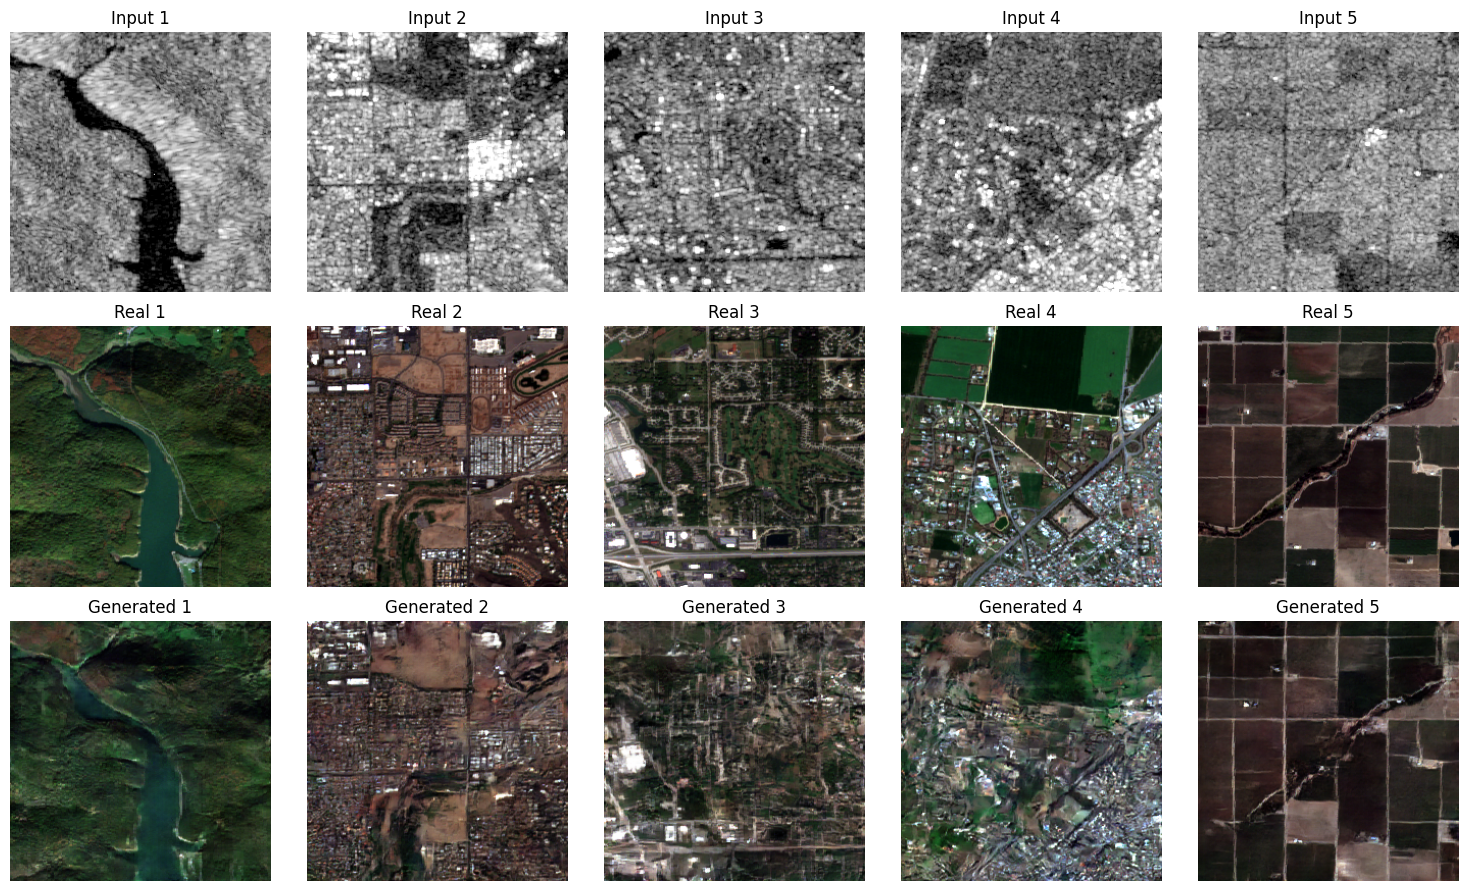

In [17]:
real_images, target_images = next(iter(dataloader))
real_images, target_images = real_images.to(DEVICE), target_images.to(DEVICE)

out = model.get_current_visuals(real_images, target_images)
real_images, target_images, generated_images = out['real'], out['target'], out['fake']

# Plot the outputs
plot_images(5, real_images, target_images, generated_images)